In [1]:
#!/usr/bin/env python3
import scipy.io.wavfile
from python_speech_features import mfcc, delta
import numpy as np
import math

import matplotlib.pyplot as plt
import pandas as pd

#if we dont graph it
#import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%%time

#i aggregate the data points for five files into aggregate.csv
files = "aggregate_no_time_column.csv"
#use just one file
#files2 = "CSVLog_20190518_122417.csv"

with open(files, 'r') as f:
    names_row = f.readline()
columns = names_row.rstrip('\n').split(',')
#debugging
#print(columns)

raw_dataset = pd.read_csv(files, names=columns,
                      sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()

CPU times: user 34.2 ms, sys: 7.87 ms, total: 42.1 ms
Wall time: 42.8 ms


In [3]:
dataset.tail()

,﻿ Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG),Total fuel economy (MPG)
6634,18.03922,11.76471,59,29.8254,29.01961,885.903,183.2,658.75,67.05882,424.9606,0.994239,5,71.6,11.51674,-0.78125,0.308259,0,0.2059091,0,30.11613
6635,17.64706,11.76471,59,29.8254,29.01961,885.903,183.2,640,67.05882,449.617,0.994239,4.5,71.6,11.51674,-0.78125,0.257985,0,0.1723274,0,30.11534
6636,17.64706,11.37255,59,29.8254,29.41176,885.903,183.2,607.75,67.05882,429.3117,0.994239,4,71.6,11.51674,-0.78125,0.325458,0,0.2173976,0,30.11455
6637,17.2549,11.37255,59,29.8254,29.41176,885.903,183.2,606.75,67.05882,449.617,0.994239,6.5,71.6,11.51674,-0.78125,0.239463,0,0.1599552,0,30.11384
6638,17.64706,11.37255,59,29.8254,29.80392,885.903,183.2,604.5,67.05882,429.3117,0.994239,6,71.6,11.51674,-0.78125,0.227556,0,0.1520016,0,30.11316


In [4]:
%%time 
#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(1234)
train, validate, test = train_validate_test_split(dataset)

#convert object to float64 first to use panda describe function
#check --> can change to assert
#train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))
#validate = validate.apply(lambda col:pd.to_numeric(col, errors='coerce'))
#test = test.apply(lambda col:pd.to_numeric(col, errors='coerce'))

train_labels = train.pop("Total fuel economy (MPG)")
validate_labels = validate.pop("Total fuel economy (MPG)")
test_labels = test.pop("Total fuel economy (MPG)")

#train_labels = train_labels.apply(lambda col:pd.to_numeric(col, errors='coerce'))
#validate_labels = validate_labels.apply(lambda col:pd.to_numeric(col, errors='coerce'))
#test_labels = test_labels.apply(lambda col:pd.to_numeric(col, errors='coerce'))

#train.loc[: , "Total fuel economy (MPG)"]

CPU times: user 9.15 ms, sys: 5.64 ms, total: 14.8 ms
Wall time: 25.5 ms


In [5]:
train.dtypes

﻿ Absolute load value (%)                        object
Absolute throttle position (%)                   object
Ambient air temperature (F)                      object
Barometric pressure (inHg)                       object
Calculated load value (%)                        object
Commanded fuel rail pressure A (inHg)            object
Engine coolant temperature (F)                   object
Engine RPM (RPM)                                 object
Fuel level input (%)                             object
Fuel rail pressure (psi)                         object
Fuel/Air commanded equivalence ratio             object
Ignition timing advance for #1 cylinder (deg)    object
Intake air temperature (F)                       object
Intake manifold absolute pressure (inHg)         object
Long term fuel % trim - Bank 1 (%)               object
Mass air flow rate (lb/min)                      object
Vehicle speed (MPH)                              object
Fuel rate (gal/hr)                              

In [6]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))
train_stats = train.describe(include = 'all')
#train_stats = train.transpose()
train_stats

,﻿ Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG)
count,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000,3983.000000
mean,34.922932,21.199313,67.566909,29.715005,42.826326,1851.707076,185.450866,1506.721253,74.584041,923.924989,0.981179,20.926688,73.319859,17.665346,5.337528,1.486570,31.305689,1.004292,60.268862
std,24.133812,13.501475,12.478003,0.838069,26.040298,1166.182589,8.646526,646.363157,10.888099,568.455580,0.035438,15.218038,13.979037,8.745762,3.918290,1.545268,22.720013,1.040012,80.449642
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000,0.000000,0.000000,-2.343750,0.050274,0.000000,0.033585,0.000000
25%,16.470590,12.156860,62.600000,29.530100,21.568630,885.903000,183.200000,1066.000000,67.450980,478.624500,0.990426,4.500000,64.400000,10.335540,2.343750,0.313551,10.563310,0.211764,11.087295
50%,25.098040,15.686270,62.600000,29.825400,38.823530,1222.546000,185.000000,1468.000000,74.509800,617.860800,0.993202,24.000000,68.000000,15.060350,5.468750,0.844074,31.068560,0.579343,31.384110
75%,49.411770,26.666670,66.200000,29.825400,56.666665,2577.978000,188.600000,1980.875000,81.176470,1271.981000,0.995490,35.000000,77.000000,27.167690,7.812500,2.210071,45.981470,1.496592,79.791765
max,98.039220,90.980390,118.400000,30.120700,100.000000,5906.020000,204.800000,4719.500000,93.333340,2987.777000,1.016230,47.000000,122.000000,30.711300,12.500000,11.959920,76.428660,8.026347,1252.727000


In [7]:
train_stats.loc['mean']

﻿ Absolute load value (%)                          34.922932
Absolute throttle position (%)                     21.199313
Ambient air temperature (F)                        67.566909
Barometric pressure (inHg)                         29.715005
Calculated load value (%)                          42.826326
Commanded fuel rail pressure A (inHg)            1851.707076
Engine coolant temperature (F)                    185.450866
Engine RPM (RPM)                                 1506.721253
Fuel level input (%)                               74.584041
Fuel rail pressure (psi)                          923.924989
Fuel/Air commanded equivalence ratio                0.981179
Ignition timing advance for #1 cylinder (deg)      20.926688
Intake air temperature (F)                         73.319859
Intake manifold absolute pressure (inHg)           17.665346
Long term fuel % trim - Bank 1 (%)                  5.337528
Mass air flow rate (lb/min)                         1.486570
Vehicle speed (MPH)     

In [8]:
#buggy 
def norm(x):
  return (x - train_stats.loc['mean']) / train_stats.loc['std']
#normed_train = norm(train)
#normed_validate = norm(validate)
#normed_test = norm(test)


In [9]:
def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [10]:
%%time
model = build_model()
#keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)
#display(IPython.display.Image('test_keras_plot_model.png'))
#print(model.summary())
# I don't know where 140240419526080 in the picture came from

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 180 ms, sys: 11.7 ms, total: 192 ms
Wall time: 216 ms


In [11]:
%%time
#change batch size?
#try early stop?

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object = model.fit(train, train_labels, epochs=100, verbose=2,
         validation_data=(validate, validate_labels))


Train on 3983 samples, validate on 1327 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 0s - loss: 1620.9686 - mean_absolute_error: 25.3716 - mean_squared_error: 1620.9684 - val_loss: 198.5318 - val_mean_absolute_error: 11.3199 - val_mean_squared_error: 198.5318
Epoch 2/100
 - 0s - loss: 527.9521 - mean_absolute_error: 14.9828 - mean_squared_error: 527.9519 - val_loss: 24.3348 - val_mean_absolute_error: 3.6650 - val_mean_squared_error: 24.3348
Epoch 3/100
 - 0s - loss: 314.8379 - mean_absolute_error: 10.8369 - mean_squared_error: 314.8378 - val_loss: 25.4490 - val_mean_absolute_error: 3.7311 - val_mean_squared_error: 25.4490
Epoch 4/100
 - 0s - loss: 165.6786 - mean_absolute_error: 8.6946 - mean_squared_error: 165.6785 - val_loss: 29.3691 - val_mean_absolute_error: 3.9417 - val_mean_squared_error: 29.3691
Epoch 5/100
 - 0s - loss: 117.5419 - mean_absolute_error: 7.7637 - mean_squared_error: 117.5420 - val_loss: 40.4609 - val_mean_absolute_error: 5.2019 - val_mean

Epoch 45/100
 - 0s - loss: 8.9125 - mean_absolute_error: 2.1784 - mean_squared_error: 8.9125 - val_loss: 7.3032 - val_mean_absolute_error: 1.8845 - val_mean_squared_error: 7.3032
Epoch 46/100
 - 0s - loss: 8.5712 - mean_absolute_error: 2.1169 - mean_squared_error: 8.5712 - val_loss: 6.3486 - val_mean_absolute_error: 1.7074 - val_mean_squared_error: 6.3486
Epoch 47/100
 - 0s - loss: 8.5302 - mean_absolute_error: 2.1187 - mean_squared_error: 8.5302 - val_loss: 7.9386 - val_mean_absolute_error: 2.2663 - val_mean_squared_error: 7.9386
Epoch 48/100
 - 0s - loss: 8.5237 - mean_absolute_error: 2.1151 - mean_squared_error: 8.5237 - val_loss: 8.2091 - val_mean_absolute_error: 2.2403 - val_mean_squared_error: 8.2091
Epoch 49/100
 - 0s - loss: 8.7592 - mean_absolute_error: 2.1147 - mean_squared_error: 8.7592 - val_loss: 5.8215 - val_mean_absolute_error: 1.5569 - val_mean_squared_error: 5.8215
Epoch 50/100
 - 0s - loss: 8.0477 - mean_absolute_error: 2.0409 - mean_squared_error: 8.0477 - val_loss: 

Epoch 91/100
 - 0s - loss: 6.4495 - mean_absolute_error: 1.8029 - mean_squared_error: 6.4495 - val_loss: 6.0004 - val_mean_absolute_error: 1.6786 - val_mean_squared_error: 6.0004
Epoch 92/100
 - 0s - loss: 6.5378 - mean_absolute_error: 1.7818 - mean_squared_error: 6.5378 - val_loss: 7.5259 - val_mean_absolute_error: 2.0181 - val_mean_squared_error: 7.5259
Epoch 93/100
 - 0s - loss: 6.3168 - mean_absolute_error: 1.7802 - mean_squared_error: 6.3168 - val_loss: 12.1432 - val_mean_absolute_error: 2.8782 - val_mean_squared_error: 12.1432
Epoch 94/100
 - 0s - loss: 6.1842 - mean_absolute_error: 1.7532 - mean_squared_error: 6.1842 - val_loss: 8.6081 - val_mean_absolute_error: 2.4472 - val_mean_squared_error: 8.6081
Epoch 95/100
 - 0s - loss: 6.3560 - mean_absolute_error: 1.7893 - mean_squared_error: 6.3560 - val_loss: 5.3227 - val_mean_absolute_error: 1.6179 - val_mean_squared_error: 5.3227
Epoch 96/100
 - 0s - loss: 6.1920 - mean_absolute_error: 1.7574 - mean_squared_error: 6.1920 - val_loss

In [12]:
#history_object.history

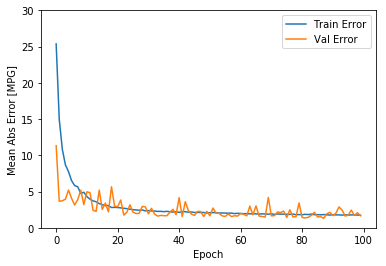

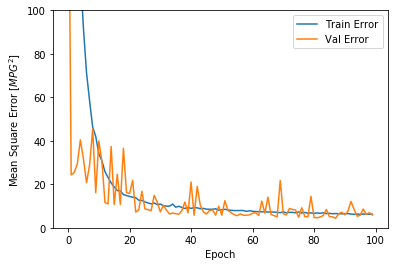

In [17]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()
  plt.show()


plot_history(history_object)

In [14]:
#loss, mae, mse = model.evaluate(test, test_labels, verbose=2)
